# BCM for aggreagated months with heterogeneous noise

7th March 2024


In [1]:
# Import libraries
import glob
import gpflow

import scipy as sp
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from gpflow.conditionals.util import sample_mvn

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import tqdm

In [3]:
# Custom libraries
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/')
import guepard
from models import bcm
from utils.areal_plots import seasonal_means

In [4]:
# import sklearn scaler
from sklearn.preprocessing import StandardScaler

In [31]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and prepare data

In [6]:
rcm_list = []
lambdas = []
scalers = []
p95_list = []


for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical*2006.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df[(df['lon'] > 60) & (df['lat'] > 30) & (df['lon'] < 70) & (df['lat'] < 35)]
    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    p95 = np.percentile(loc_df['tp'], 95)

    y_scaler = StandardScaler()
    loc_df['tp_bc'], lmbda = sp.stats.boxcox(loc_df['tp']+0.001)
    tp_tr = y_scaler.fit_transform(loc_df['tp_bc'].values.reshape(-1, 1))
    loc_df['tp_tr'] = tp_tr

    scalers.append(y_scaler)
    p95_list.append(p95)
    lambdas.append(lmbda)
    rcm_list.append(loc_df[['month', 'lon', 'lat', 'tp_tr']])


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI-REMO2009_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_CSIRO_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI_IITM_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_NOAA_SMHI1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MIROC_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


In [7]:
rcm_df = rcm_list[1]

In [8]:
rcm_df

,month,lon,lat,tp_tr
20,1,60.25,30.25,0.781021
43220,1,60.25,30.25,0.864232
86420,1,60.25,30.25,-0.873850
129620,1,60.25,30.25,-0.079758
172820,1,60.25,30.25,-0.293354
...,...,...,...,...
1120389,12,69.75,34.75,-0.435015
1163589,12,69.75,34.75,-0.075647
1206789,12,69.75,34.75,0.802416
1249989,12,69.75,34.75,0.852062


<Axes: >

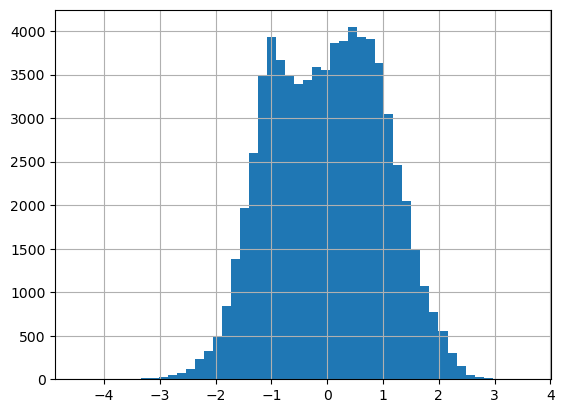

In [9]:
rcm_df['tp_tr'].hist(bins=50)

## Fit warped GP to aggregated data

In [10]:
# using groupby, crate catergories along lon and lat columns, for rcm_df
rcm_df['lat_group'] = pd.cut(rcm_df['lat'], 5, labels=np.arange(5))
rcm_df['lon_group'] = pd.cut(rcm_df['lon'], 5, labels=np.arange(5))

In [11]:
df_list = []
gb = rcm_df.groupby(['lon_group', 'lat_group',])
df_list.extend([gb.get_group(x)[['month', 'lon', 'lat', 'tp_tr',]].values for x in gb.groups])

In [12]:
arr = np.array(df_list)
arr.shape

(25, 2880, 4)

In [13]:
Xl = arr[:, :, :3]
Yl = arr[:, :, 3][:, :, None]
Zl = arr[:, ::30, :3]

In [14]:
Yl.shape

(25, 2880, 1)

In [32]:
likelihood = gpflow.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

In [33]:
kernel = gpflow.kernels.SeparateIndependent(
    [
        gpflow.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpflow.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)

In [34]:
Ml = (np.ones(len(Xl)) * arr.shape[1]/30).astype(int)
submodels = bcm.get_latent_submodels(Xl, Zl, kernel=kernel, likelihood=likelihood)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 139.55it/s]


In [35]:
m_bcm1 = guepard.baselines.latent_Ensemble(
    models=submodels, method=guepard.baselines.EnsembleMethods.RBCM, weighting=guepard.baselines.WeightingMethods.VAR)

In [36]:
gpflow.utilities.set_trainable(m_bcm1.models[0].inducing_variable.inducing_variable_list[0].Z, False)
gpflow.utilities.set_trainable(m_bcm1.models[0].inducing_variable.inducing_variable_list[1].Z, False)
gpflow.utilities.set_trainable(m_bcm1.models[1].inducing_variable.inducing_variable_list[0].Z, False)
gpflow.utilities.set_trainable(m_bcm1.models[1].inducing_variable.inducing_variable_list[1].Z, False)

In [37]:
# print properties of class
m_bcm1

name,class,transform,prior,trainable,shape,dtype,value
latent_Ensemble.kernel.kernels[0].variance latent_Ensemble.models[0].kernel.kernels[0].variance latent_Ensemble.models[1].kernel.kernels[0].variance latent_Ensemble.models[2].kernel.kernels[0].variance latent_Ensemble.models[3].kernel.kernels[0].variance latent_Ensemble.models[4].kernel.kernels[0].variance latent_Ensemble.models[5].kernel.kernels[0].variance latent_Ensemble.models[6].kernel.kernels[0].variance latent_Ensemble.models[7].kernel.kernels[0].variance latent_Ensemble.models[8].kernel.kernels[0].variance latent_Ensemble.models[9].kernel.kernels[0].variance latent_Ensemble.models[10].kernel.kernels[0].variance latent_Ensemble.models[11].kernel.kernels[0].variance latent_Ensemble.models[12].kernel.kernels[0].variance latent_Ensemble.models[13].kernel.kernels[0].variance latent_Ensemble.models[14].kernel.kernels[0].variance latent_Ensemble.models[15].kernel.kernels[0].variance latent_Ensemble.models[16].kernel.kernels[0].variance latent_Ensemble.models[17].kernel.kernels[0].variance latent_Ensemble.models[18].kernel.kernels[0].variance latent_Ensemble.models[19].kernel.kernels[0].variance latent_Ensemble.models[20].kernel.kernels[0].variance latent_Ensemble.models[21].kernel.kernels[0].variance latent_Ensemble.models[22].kernel.kernels[0].variance latent_Ensemble.models[23].kernel.kernels[0].variance latent_Ensemble.models[24].kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
latent_Ensemble.kernel.kernels[0].lengthscales latent_Ensemble.models[0].kernel.kernels[0].lengthscales latent_Ensemble.models[1].kernel.kernels[0].lengthscales latent_Ensemble.models[2].kernel.kernels[0].lengthscales latent_Ensemble.models[3].kernel.kernels[0].lengthscales latent_Ensemble.models[4].kernel.kernels[0].lengthscales latent_Ensemble.models[5].kernel.kernels[0].lengthscales latent_Ensemble.models[6].kernel.kernels[0].lengthscales latent_Ensemble.models[7].kernel.kernels[0].lengthscales latent_Ensemble.models[8].kernel.kernels[0].lengthscales latent_Ensemble.models[9].kernel.kernels[0].lengthscales latent_Ensemble.models[10].kernel.kernels[0].lengthscales latent_Ensemble.models[11].kernel.kernels[0].lengthscales latent_Ensemble.models[12].kernel.kernels[0].lengthscales latent_Ensemble.models[13].kernel.kernels[0].lengthscales latent_Ensemble.models[14].kernel.kernels[0].lengthscales latent_Ensemble.models[15].kernel.kernels[0].lengthscales latent_Ensemble.models[16].kernel.kernels[0].lengthscales latent_Ensemble.models[17].kernel.kernels[0].lengthscales latent_Ensemble.models[18].kernel.kernels[0].lengthscales latent_Ensemble.models[19].kernel.kernels[0].lengthscales latent_Ensemble.models[20].kernel.kernels[0].lengthscales latent_Ensemble.models[21].kernel.kernels[0].lengthscales latent_Ensemble.models[22].kernel.kernels[0].lengthscales latent_Ensemble.models[23].kernel.kernels[0].lengthscales latent_Ensemble.models[24].kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
latent_Ensemble.kernel.kernels[1].variance latent_Ensemble.models[0].kernel.kernels[1].variance latent_Ensemble.models[1].kernel.kernels[1].variance latent_Ensemble.models[2].kernel.kernels[1].variance latent_Ensemble.models[3].kernel.kernels[1].variance latent_Ensemble.models[4].kernel.kernels[1].variance latent_Ensemble.models[5].kernel.kernels[1].variance latent_Ensemble.models[6].kernel.kernels[1].variance latent_Ensemble.models[7].kernel.kernels[1].variance latent_Ensemble.models[8].kernel.kernels[1].variance latent_Ensemble.models[9].kernel.kernels[1].variance latent_Ensemble.models[10].kernel.kernels[1].variance latent_Ensemble.models[11].kernel.kernels[1].variance latent_Ensemble.models[12].kernel.kernels[1].variance latent_Ensemble.models[13].kernel.kernels[1].variance latent_Ensemble.models[14].kernel.kernels[1].variance latent_Ensemble.models[15].kernel.kernels[1].variance latent_Ensemble.models[16].kernel.kernels[1].variance latent_Ensemble.models[17].kernel.kernels[1]

In [38]:
m_bcm1.models[0]

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,False,"(96, 3)",float64,"[[1., 60.25, 30.25..."
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,False,"(96, 3)",float64,"[[1., 60.25, 30.25..."
SVGP.q_mu,Parameter,Identity,,False,"(96, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 96, 96)",float64,"[[[1., 0., 0...."


In [39]:
loss_fn = m_bcm1.training_loss(Xl, Yl)

variational_vars = m_bcm1.variational_variables
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

adam_vars = tuple(m_bcm1.trainable_variables)
adam_opt = tf.optimizers.Adam(0.001)

# @tf.function
def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

In [40]:
epochs = 20
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")

Epoch 20 - Loss:  87995.1543


## Predictions

In [29]:
X_plt = Zl.reshape(-1, 3)

### Samples

In [ ]:
def samples(x:np.ndarray, model:gpflow.models, num_samples:int=1,) -> np.ndarray:
    """ Returns samples from latent model."""
    f_preds, g_preds  = model.predict_f(x)
    std = np.sqrt(np.exp(g_preds[:, 0]))
    mu = f_preds[:, 0]
    return np.random.randn(g_preds.shape[0], num_samples)*std + mu

In [30]:
F = m_bcm1.predict_f(X_plt, full_cov=False, full_output_cov=False)
#samples = F.numpy().squeeze()

KeyboardInterrupt: 

In [ ]:
m_bcm1.predict_f(X_plt)

(array([[-0.41519733,  0.02356626],
        [-0.38894979,  0.01903182],
        [-0.40998945,  0.01399154],
        ...,
        [ 0.38885312,  0.00823471],
        [ 0.0102689 ,  0.01520207],
        [ 0.46735957,  0.01324772]]),
 array([[-0.18419036,  0.02207608],
        [-0.24775198,  0.02140254],
        [-0.22913096,  0.0153962 ],
        ...,
        [-0.32946299,  0.01227997],
        [-0.15227444,  0.01488199],
        [-0.29102282,  0.01729625]]))

In [ ]:
df = pd.DataFrame(samples.T, columns=["s1", "s2", "s3"])
df_melt = df.melt(var_name="sample", value_name="pr")

ValueError: Must pass 2-d input. shape=(2, 2400, 3)

In [ ]:
# Check pdfs of data and sample
plt.figure()
n0, bins0, patches0 = plt.hist(arr_out, bins=50, alpha=0.5, label="data", density=True)
n1, bins1, patches1 = plt.hist(df['s1'].values, bins=bins0, alpha=0.5, label="s1", density=True)
n1, bins1, patches1 = plt.hist(df['s2'].values, bins=bins0, alpha=0.5, label="s2", density=True)
n1, bins1, patches1 = plt.hist(df['s3'].values, bins=bins0, alpha=0.5, label="s3",density=True)
plt.legend()

NameError: name 'arr_out' is not defined

<Figure size 640x480 with 0 Axes>

### Timeseries plot

In [41]:
months = np.linspace(1, 12, 100).reshape(-1, 1)
loc_rep = np.tile([69.25, 31.25], (100,1))
ts_input = np.hstack([months, loc_rep])

In [42]:
ypred, var = m_bcm1.predict_y(ts_input)
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [43]:
df_temp['y_pred'] = df_temp['pred0'].values
df_temp['95th_u'] = df_temp['pred0'].values + 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['95th_l'] = df_temp['pred0'].values - 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)
df_temp[['time', 'lon', 'lat']] = ts_input

In [44]:
df_temp

,pred0,var0,y_pred,95th_u,95th_l,CI,time,lon,lat
0,-0.883794,0.769542,-0.883794,0.835587,-2.603176,3.438763,1.000000,69.25,31.25
1,-0.929309,0.716534,-0.929309,0.729798,-2.588417,3.318216,1.111111,69.25,31.25
2,-0.959676,0.685746,-0.959676,0.663396,-2.582747,3.246143,1.222222,69.25,31.25
3,-0.972969,0.668609,-0.972969,0.629693,-2.575632,3.205325,1.333333,69.25,31.25
4,-0.967782,0.658663,-0.967782,0.622916,-2.558480,3.181396,1.444444,69.25,31.25
...,...,...,...,...,...,...,...,...,...
95,-0.811558,0.557724,-0.811558,0.652188,-2.275304,2.927492,11.555556,69.25,31.25
96,-0.871514,0.574728,-0.871514,0.614378,-2.357406,2.971785,11.666667,69.25,31.25
97,-0.933454,0.596025,-0.933454,0.579718,-2.446626,3.026343,11.777778,69.25,31.25
98,-0.993785,0.626360,-0.993785,0.557416,-2.544987,3.102403,11.888889,69.25,31.25


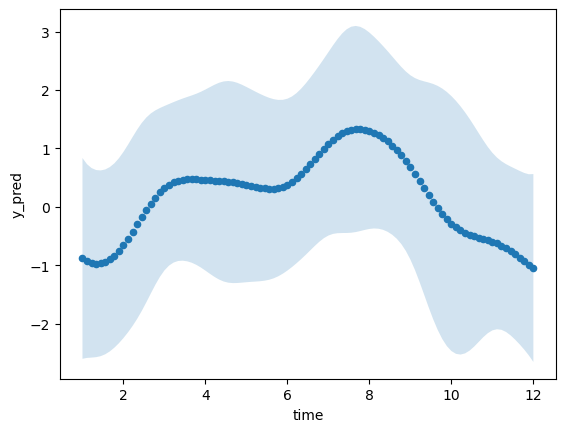

In [45]:
df_temp.plot.scatter(x='time', y='y_pred')
plt.fill_between(df_temp['time'], df_temp['95th_l'], df_temp['95th_u'], alpha=0.2)

### Small subset of data

In [46]:
#arr_in[arr_in[:, 0] == 12., :].shape
check_input = X_plt #arr_in[arr_in[:, 0] == 12., :]

In [47]:
ypred, var = m_bcm1.predict_y(check_input, full_cov=False, full_output_cov=False)#np.array(Xl).reshape(-1,3))
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [48]:
df_temp['y_pred'] = df_temp['pred0'].values
df_temp['95th_u'] = df_temp['pred0'].values + 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['95th_l'] = df_temp['pred0'].values - 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)
df_temp[['time', 'lon', 'lat']] =check_input

In [49]:
df_temp[['y_pred', '95th_u', '95th_l', 'CI']] = df_temp[[
    'y_pred', '95th_u', '95th_l', 'CI']].fillna(0)

# To Data Array
df_temp.set_index(['time', 'lon', 'lat'], inplace=True)

In [50]:
Xl.shape

(25, 2880, 3)

Text(0.5, 1.0, 'Variance of Predictions')

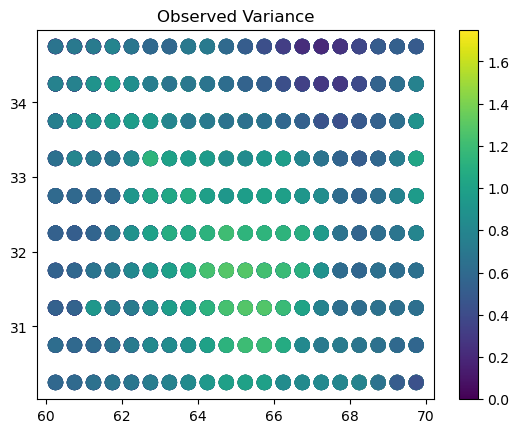

<Figure size 640x480 with 0 Axes>

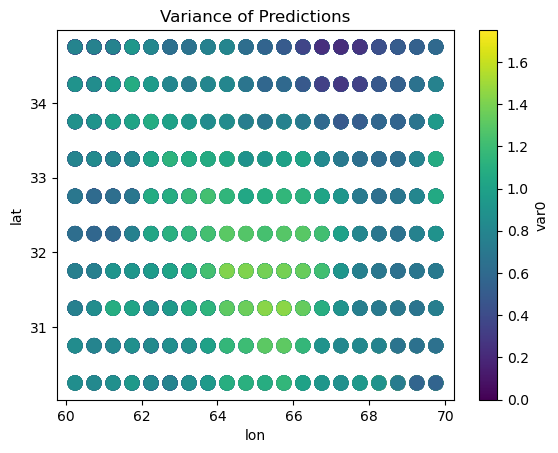

In [57]:
plt.figure()
plt.scatter(Xl[:, ::30, 1].reshape(-1), Xl[:, ::30, 2].reshape(-1), 
            c=np.var(Yl.reshape(25, -1, 30, 1), axis=-2).reshape(-1),
            s=100, vmin=0, vmax=1.75,)
plt.colorbar()
plt.title('Observed Variance')

plt.figure()
df_temp.reset_index().plot.scatter(x='lon', y='lat', c='var0',
                                   vmin=0, vmax=1.75, s=100)
plt.title('Variance of Predictions')

Text(0.5, 1.0, 'Mean of Predictions')

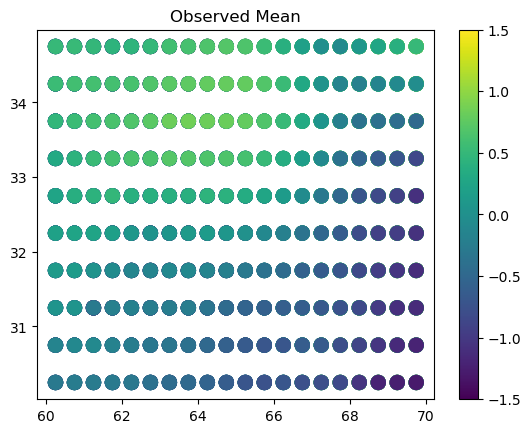

<Figure size 640x480 with 0 Axes>

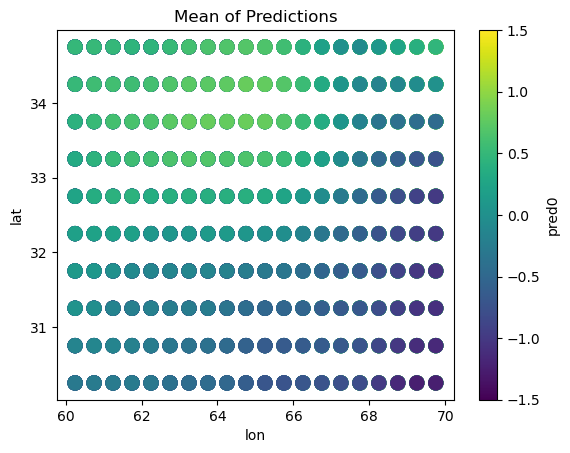

In [60]:
plt.figure()
plt.scatter(Xl[:, ::30, 1].reshape(-1), Xl[:, ::30, 2].reshape(-1), 
            c=np.mean(Yl.reshape(25, -1, 30, 1), axis=-2).reshape(-1),
            s=100, vmin=-1.5, vmax=1.5 )
plt.colorbar()
plt.title('Observed Mean')

plt.figure()
df_temp.reset_index().plot.scatter(x='lon', y='lat', c='pred0',
                                    s=100, vmin=-1.5, vmax=1.5)
plt.title('Mean of Predictions')


In [53]:
#df_temp.drop_duplicates(inplace=True)
ds = df_temp.to_xarray()

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/3992662662.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g1.axes.flat:
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1605/3992662662.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g2.axes.flat:


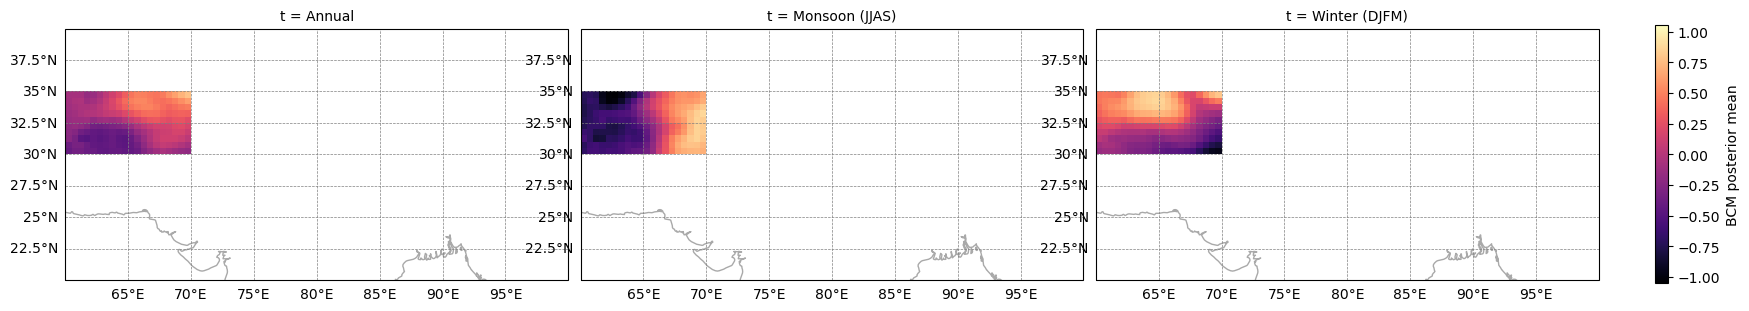

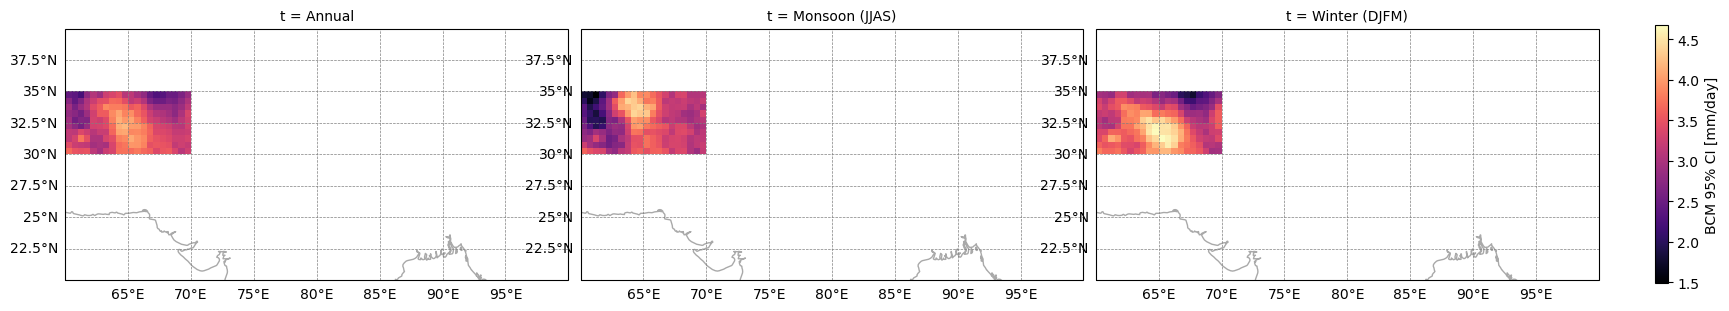

In [54]:
proj = ccrs.PlateCarree()
ds_avg_ypred = seasonal_means(ds.y_pred, 'y_pred')
ds_avg_CI = seasonal_means(ds.CI, 'CI')

# Map

ocean_50m = cf.NaturalEarthFeature("physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

g1 = ds_avg_ypred.plot(x="lon", y="lat", col="t", aspect=2, size=3, subplot_kws={"projection": proj}, cbar_kwargs={
    "label": "BCM posterior mean", 'pad': 0.03}, cmap='magma')

for ax in g1.axes.flat:
    ax.add_feature(ocean_50m)
    ax.set_extent([60, 100, 20, 40], crs=proj)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False

g2 = ds_avg_CI.plot(x="lon", y="lat", col="t",  aspect=2, cmap='magma', cbar_kwargs={
    "label": "BCM 95% CI [mm/day]", 'pad':0.03}, size=3, subplot_kws={"projection": proj})

for ax in g2.axes.flat:
    ax.add_feature(ocean_50m)
    ax.set_extent([60, 100, 20, 40], crs=proj)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False